In [409]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import os
import arch
from sklearn.linear_model import LinearRegression

# Data Cleaning

In [ ]:
#Data cleaning 
file_names_lst = ["DIA.csv", "FEZ.csv", "IJH.csv", "IWD.csv", "IWF.csv",
                  "IWM.csv", "IWN.csv", "IWO.csv", "MDY.csv", "OEF.csv", "QQQ.csv", "SPY.csv", "VTI.csv"]
equity_names_lst = ["DIA", "FEZ", "IJH", "IWD", "IWF",
                    "IWM", "IWN", "IWO", "MDY", "OEF", "QQQ", "SPY", "VTI"]
uni_daily_prices = pd.DataFrame() # Dataframe with daily Adj Close
uni_daily_handl_prices = pd.DataFrame() # Dataframe with daily high and daily low
uni_daily_range = pd.DataFrame() # Dataframe with daily range(calculated by ln(high/low))
for i in range(len(file_names_lst)):
    file_name = file_names_lst[i]
    equity_name = equity_names_lst[i]
    df = pd.read_csv(file_name)
    df = df[['Date', 'Adj Close', 'High', 'Low']]
    df['Daily Range'] = np.log(df["High"]/df["Low"])
    df['Date'] = pd.to_datetime(df['Date'])
    cutoff_date = pd.to_datetime('2005-01-01')
    df = df.loc[df['Date'] > cutoff_date, :]
    if i == 0:
        uni_daily_prices['Date'] = df['Date']
        uni_daily_handl_prices['Date'] = df['Date']
        uni_daily_range['Date'] = df['Date']
        uni_daily_prices.set_index('Date', inplace=True)
        uni_daily_handl_prices.set_index('Date', inplace=True)
        uni_daily_range.set_index('Date', inplace=True)
    df.set_index('Date', inplace=True)
    uni_daily_prices[equity_name] = df["Adj Close"]
    uni_daily_handl_prices[equity_name + " High"] = df["High"]
    uni_daily_handl_prices[equity_name + " Low"] = df["Low"]
    uni_daily_range[equity_name] = df["Daily Range"]
uni_daily_returns_df = uni_daily_prices.pct_change()
uni_monthly_prices = uni_daily_prices.resample('M').last()
uni_monthly_returns_df = uni_monthly_prices.pct_change()
uni_daily_returns_df = uni_daily_returns_df.iloc[1:]

# Find Pair

In [ ]:
# Find the minimum value of SSD(sum of squared difference) among each pair of return of indexes
def SSD(df):
    ssd_df = pd.DataFrame(index = ['SSD'])
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            # calculate SSD between columns i and j
            col1 = df.iloc[:, i]
            col2 = df.iloc[:, j]
            ssd = ((col1 - col2) ** 2).sum()
            
            # store result in ssd_df
            colname = f"{df.columns[i]}-{df.columns[j]}"
            ssd_df[colname] = [ssd]
    
    return ssd_df
ssd_daily_df = SSD(uni_daily_returns_df).T
min_ssd_daily = ssd_daily_df.idxmin(axis=0)[0]
ssd_daily_df.sort_values(by='SSD', ascending=True, inplace=True)

print(ssd_daily_df)

print(f"Minimum SSD value(daily) is {ssd_daily_df['SSD'][min_ssd_daily]} in column '{min_ssd_daily}'")
# Minimum SSD value(daily) is 0.009802063661051762 in column 'SPY-VTI' when the indexes are ['DIA','FEZ','IJH','IWD','IWF','IWM','IWN','IWO','MDY','OEF','QQQ','SPY','VTI']


In [ ]:
# Find the best kendall tau rate to further support pair searching
from scipy.stats import kendalltau

def Kendall_Tau(df):
    kendall_df = pd.DataFrame(index = ['KT'])
    # iterate over column pairs
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            # calculate Kendall tau correlation between columns i and j
            col1 = df.iloc[:, i]
            col2 = df.iloc[:, j]
            tau, pval = kendalltau(col1, col2)
            # store result in kendall_df
            colname = f"{df.columns[i]}-{df.columns[j]}"
            kendall_df[colname] = [tau]
    # print results
    return kendall_df

kt_daily_df = Kendall_Tau(uni_daily_returns_df).T
max_kt_daily = kt_daily_df.idxmax(axis=0)[0]
kt_daily_df.sort_values(by='KT', ascending=False, inplace=True)

print(kt_daily_df)
print(f"Maximum KT value(daily) is {kt_daily_df['KT'][max_kt_daily]} in column '{max_kt_daily}'")
# Maximum KT value(daily) is 0.9443723187207665 in column 'IJH-MDY'

# Copulas

Please check R studio Code for this section

# Backtesting

## Data Preparation

In [697]:
path = r"C:\Users\12451\OneDrive\桌面\BU\2023 Spring\IAQF\\Data\\"
csv_l = ["IJH.csv", "MDY.csv", "SPY.csv", "VTI.csv"]

In [571]:
returns = pd.read_csv(path + 'daily_returns.csv')
returns.head(2)

,Date,DIA,FEZ,IJH,IWD,IWF,IWM,IWN,IWO,MDY,OEF,QQQ,SPY,VTI
0,2005-01-04,-0.009504,-0.016792,-0.016245,-0.008224,-0.013966,-0.021436,-0.018091,-0.025340,-0.018289,-0.009118,-0.018227,-0.012219,-0.013310
1,2005-01-05,-0.005550,-0.001275,-0.009970,-0.006296,-0.006665,-0.019987,-0.019973,-0.017332,-0.013186,-0.002654,-0.006189,-0.006901,-0.006918


In [572]:
#Merge data. Keep rows with same date (IJH-MDY)
IJH = pd.read_csv(path+csv_l[0])
MDY = pd.read_csv(path+csv_l[1])
IJH = IJH.merge(MDY, on='Date')

In [732]:
#Merge data. Keep rows with same date (SPY-VTI)
SPY = pd.read_csv(path+csv_l[2])
VTI = pd.read_csv(path+csv_l[3])
SPY = SPY.merge(VTI, on='Date')

In [579]:
# Volatility proxy for IJH-MDY 
temp_ijh = np.log(np.array(IJH['High_x'])/np.array(IJH['Low_x']))
temp_mdy = np.log(np.array(IJH['High_y'])/np.array(IJH['Low_y']))
d = {'IJH':temp_ijh, 'MDY':temp_mdy}
# The length will be 1 larger than the return dataframes, so the last element should be deleted when needed
uni_daily_range = pd.DataFrame(data=d) 

In [733]:
# Volatility proxy for SPY-VTI
temp_spy = np.log(np.array(SPY['High_x'])/np.array(SPY['Low_x']))
temp_vti = np.log(np.array(SPY['High_y'])/np.array(SPY['Low_y']))
d = {'SPY':temp_spy, 'VTI':temp_vti}
# The length will be 1 larger than the return dataframes, so the last element should be deleted when needed
sv_daily_range = pd.DataFrame(data=d) 
sv_daily_range.head(5)

,SPY,VTI
0,0.011516,0.007004
1,0.023386,0.022410
2,0.014151,0.013436
3,0.008803,0.005338
4,0.020266,0.017448


In [6]:
IJH_MDY = IJH[["Date", "Adj Close_x","Adj Close_y"]]
IJH_MDY = IJH_MDY.rename({"Adj Close_x": "IJH", "Adj Close_y": "MDY"}, axis = 'columns')
IJH_MDY.head()

,Date,IJH,MDY
0,2000-07-20,37.935215,72.459839
1,2000-07-21,37.431396,70.920128
2,2000-07-24,37.107128,70.439003
3,2000-07-25,36.921825,70.607445
4,2000-07-26,36.782845,70.174393


In [8]:
# Create Return Dataframe for IJH-MDY
IJH_r = np.array(IJH_MDY["IJH"][1:]) / np.array(IJH_MDY["IJH"][:-1]) -1
MDY_r = np.array(IJH_MDY["MDY"][1:]) / np.array(IJH_MDY["MDY"][:-1]) -1
d = {'Date': IJH_MDY['Date'][1:], 'IJH': IJH_r, 'MDY': MDY_r}
# The return on time t is calculated by p_t/p_(t-1), i.e. the close price on t divided by the close price on t-1
IJH_MDY_r = pd.DataFrame(data=d)
# Write the return csv to path
IJH_MDY_r.to_csv(os.path.join(path,r'IJH_MDY_r.csv'))
IJH_MDY_r.head()

,Date,IJH,MDY
1,2000-07-21,-0.013281,-0.021249
2,2000-07-24,-0.008663,-0.006784
3,2000-07-25,-0.004994,0.002391
4,2000-07-26,-0.003764,-0.006133
5,2000-07-27,-0.011178,-0.016113


In [727]:
# Create Return Dataframe for SPY-VTI
SPY_VTI = SPY[["Date", "Adj Close_x","Adj Close_y"]]
SPY_VTI = SPY_VTI.rename({"Adj Close_x": "SPY", "Adj Close_y": "VTI"}, axis = 'columns')
SPY_r = np.array(SPY_VTI["SPY"][1:]) / np.array(SPY_VTI["SPY"][:-1]) -1
VTI_r = np.array(SPY_VTI["VTI"][1:]) / np.array(SPY_VTI["VTI"][:-1]) -1

d = {'Date': SPY_VTI['Date'][1:], 'SPY': SPY_r, 'VTI': VTI_r}
# The return on time t is calculated by p_t/p_(t-1), i.e. the close price on t divided by the close price on t-1
SPY_VTI_r = pd.DataFrame(data=d)
# Write the return csv to path
SPY_VTI_r.to_csv(os.path.join(path,r'SPY_VTI_r.csv'))
SPY_VTI_r.head()

,Date,SPY,VTI
1,2001-08-21,-0.017059,-0.013967
2,2001-08-22,0.010361,0.009254
3,2001-08-23,-0.003589,-0.001310
4,2001-08-24,0.020754,0.018269
5,2001-08-27,-0.005966,-0.003588


In [728]:
len(SPY_VTI_r)

5408

In [9]:
def train_test_split(df, split_ratio):
    cutoff = int(len(df)*split_ratio)
    train = df[:cutoff]
    test = df[cutoff:]
    return train, test

In [462]:
# Train-test split 90:10 for IJH-MDY
split_ratio = 0.9
IJH_MDY_train, IJH_MDY_test = train_test_split(IJH_MDY_r, split_ratio)
# Write sets to csv
IJH_MDY_train.to_csv(os.path.join(path,r'IJH_MDY_train.csv'))
IJH_MDY_test.to_csv(os.path.join(path,r'IJH_MDY_test.csv'))

In [11]:
IJH_MDY_train.tail(2)

,Date,IJH,MDY
4543,2018-08-10,-0.005637,-0.005665
4544,2018-08-13,-0.005217,-0.005092


In [12]:
IJH_MDY_test.head(2)

,Date,IJH,MDY
4545,2018-08-14,0.009228,0.009241
4546,2018-08-15,-0.009144,-0.009348


## Estimate hedge ratio with Volatility Proxy

In [581]:
def daily_volproxy_estimation(df, indx):
    
    pred_df = pd.DataFrame()
    
    y = df[indx].values
    x = df[indx].values
    y = y[1:]
    x = x[:-1]
    x = x.reshape((-1,1))

    model = LinearRegression()
    reg = model.fit(x, y)
    beta = reg.coef_
    y_pred = model.predict(x)
    
    pred_df = pd.DataFrame(y_pred,columns = [indx])
    return pred_df

In [708]:
# Volatility proxy hedge ratio for IJH-MDY
pred_daily_vol_df = pd.DataFrame()
pred_daily_vol_df['IJH'] = daily_volproxy_estimation(uni_daily_range, 'IJH')
pred_daily_vol_df['MDY'] = daily_volproxy_estimation(uni_daily_range, 'MDY')

corr_vector = [1,1]
for k in pred_daily_vol_df.index.tolist()[2:]:
    corr = np.corrcoef(IJH_MDY_train['IJH'][:k], IJH_MDY_train['MDY'][:k])[0,1]
    corr_vector.append(corr)
corr_df = pd.DataFrame(corr_vector)

hedge_volproxy_df = pd.DataFrame()
# coefficient = std(y)/std(x)*corr(x,y)
hedge_volproxy_df[f"{'IJH'} to {'MDY'}"] = corr_df.iloc[:,0] * pred_daily_vol_df['IJH']/pred_daily_vol_df['MDY']
hedge_volproxy_df

,IJH to MDY
0,0.877086
1,0.679959
2,0.801322
3,0.973289
4,0.790156
...,...
5676,1.149909
5677,0.979149
5678,0.936219
5679,0.998877


In [738]:
# Valatility proxy for SPY-VTI
pred_daily_vol_df = pd.DataFrame()
pred_daily_vol_df['SPY'] = daily_volproxy_estimation(sv_daily_range, 'SPY')
pred_daily_vol_df['VTI'] = daily_volproxy_estimation(sv_daily_range, 'VTI')

corr_vector = [1,1]
for k in pred_daily_vol_df.index.tolist()[2:]:
    corr = np.corrcoef(SPY_VTI_train['SPY'][:k], SPY_VTI_train['VTI'][:k])[0,1]
    corr_vector.append(corr)
corr_df = pd.DataFrame(corr_vector)

sv_hedge_volproxy_df = pd.DataFrame()
# coefficient = std(y)/std(x)*corr(x,y)
sv_hedge_volproxy_df[f"{'SPY'} to {'VTI'}"] = corr_df.iloc[:,0] * pred_daily_vol_df['SPY']/pred_daily_vol_df['VTI']
sv_hedge_volproxy_df

,SPY to VTI
0,1.142451
1,1.233457
2,1.064474
3,1.021130
4,1.245351
...,...
5403,0.880234
5404,0.948265
5405,1.059334
5406,0.936246


## Estimate hedge ratio with Kalman Filter 

In [13]:
# Hedge ratio Calculation
def calc_slope_intercept_kalman(df, etfs):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    # X_t
    obs_mat = np.vstack([df[etfs[0]] , np.ones(df[etfs[0]].shape)]).T[:, np.newaxis] 
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    state_means, state_covs = kf.filter(df[etfs[1]])
    return state_means, state_covs

In [463]:
# Kalman filter hedge ratio for IJH-MDY

# Convert the returns in terms of percentage
temp = IJH_MDY_train[["IJH", "MDY"]] * 100
# Calculate hedge ratio
pair_delta, pair_cov = calc_slope_intercept_kalman(temp, ["IJH", "MDY"])

In [748]:
# Kalman filter hedge ratio for SPY-VTI
temp = SPY_VTI_r[["SPY", "VTI"]] * 100
sv_pair_dalta, sv_pari_cov = calc_slope_intercept_kalman(temp, ["SPY", "VTI"])

In [15]:
def draw_slope_intercept_changes(df, state_means):
    """
    Plot the slope and intercept changes from the 
    Kalman Filte calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=df.index
    ).plot(subplots=True)
    plt.show()

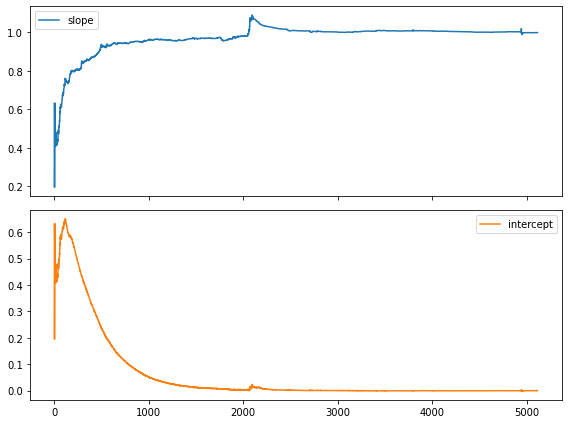

In [464]:
draw_slope_intercept_changes(IJH_MDY_train, pair_delta)

In [467]:
#First element is the slope, get the hedge ratio as an array
hedge_ratio = pair_delta[:,0]
len(hedge_ratio)

5112

## Define Functions for return and win rate computation 

In [503]:
def calc_return(r, pos, tags):
    # r and pos should be dataframes. tags should be a list that contains 2 tag names
    # r should contain columns of asset returns. 
    # pos should contain 4 columns of positions first 2 columns will be combo of positions and the next 2 columns will 
    # be another combo of positions.The column names must be L1S2_1, L1S2_2, L2S1_1, L2S1_2
    
    # drop the last position as there isn't a return after the last day
    p1 = pos[["L1S2_1", "L1S2_2"]]
    p1 = p1[:-1]
    p2 = pos[["L2S1_1", "L2S1_2"]]
    p2 = p2[:-1] 
    # drop the first row of returns as there is no position for the first day
    returns = np.array([r[tags[0]], r[tags[1]]]).T
    returns = returns[1:,] 
    
    # Get total returns
    returns1 = np.dot(returns, p1.to_numpy().T)
    returns2 = np.dot(returns, p2.to_numpy().T)
    
    tol_r = (returns1.diagonal().sum() + returns2.diagonal().sum())*100
    #print("Total return = %0.3f" %tol_r + "%")
    
    return tol_r

In [381]:
def calc_winrate(r, pos, tags):
    # drop the last row as there isn't a return after the last day
    p1 = pos[["L1S2_1", "L1S2_2"]]
    p1 = p1[:-1]
    p2 = pos[["L2S1_1", "L2S1_2"]]
    p2 = p2[:-1] 
    # drop the first row of returns as there is no position for the first day
    returns = np.array([r[tags[0]], r[tags[1]]]).T
    returns = returns[1:,] 
    
    # Get total returns
    returns1 = np.dot(returns, p1.to_numpy().T)
    returns2 = np.dot(returns, p2.to_numpy().T)
    
    tol_try = abs(p1["L1S2_2"].sum()) + abs(p2["L2S1_2"].sum())
    wins_df = pd.DataFrame()
    wins_df["1"] = returns1.diagonal()
    wins_df["2"] = returns2.diagonal()
    wins_df["ifWin"] = np.where((wins_df["1"]>0) | (wins_df["2"]>0), 1, 0)
    
    winRate = float(wins_df["ifWin"].sum()/tol_try)*100
    #print("Win Rate = %0.3f" %winRate + "%")
    return winRate

## Performance with differnt thresholds

In [563]:
thresholds = np.arange(0.01, 0.5, 0.01).tolist()

In [329]:
len(hedge_ratio) == len(prob)

True

In [649]:
len(hedge_volproxy_df["IJH to MDY"]) - len(prob) 

569

In [653]:
hedge_volproxy = hedge_volproxy_df["IJH to MDY"].tolist()

In [654]:
hedge_volproxy = hedge_volproxy[:-569]

In [655]:
len(hedge_volproxy) - len(prob) 

0

In [609]:
# Estabilish Positions for the trainning set of IJH-MDY using Volatility proxy hedge ratio
tol_rs = []
winRates = []
for threshold in thresholds:
    lo = threshold
    hi = 1-lo
    tags = ["IJH", "MDY"]
    pos = pd.DataFrame()
    pos['L1S2_1'] = np.zeros(len(hedge_volproxy))
    pos['L1S2_2'] = np.zeros(len(hedge_volproxy))
    pos['L2S1_1'] = np.zeros(len(hedge_volproxy))
    pos['L2S1_2'] = np.zeros(len(hedge_volproxy))
    
    for i in range(1, len(pos)):
        if(prob['hfunc2'].tolist()[i] <= lo and prob['hfunc1'].tolist()[i] >= hi and pos['L2S1_2'].tolist()[i-1] <= 0):
            pos.iloc[i,0] = 1
            pos.iloc[i,1] = -hedge_volproxy[i]
    
        if(prob['hfunc1'].tolist()[i] <= lo and prob['hfunc2'].tolist()[i] >= hi and pos['L1S2_1'].tolist()[i-1] >= 0):
            pos.iloc[i,2] = -1
            pos.iloc[i,3] = hedge_volproxy[i]
    
    tol_rs.append(calc_return(IJH_MDY_train[:-1], pos, tags))
    winRates.append(calc_winrate(IJH_MDY_train[:-1], pos, tags))

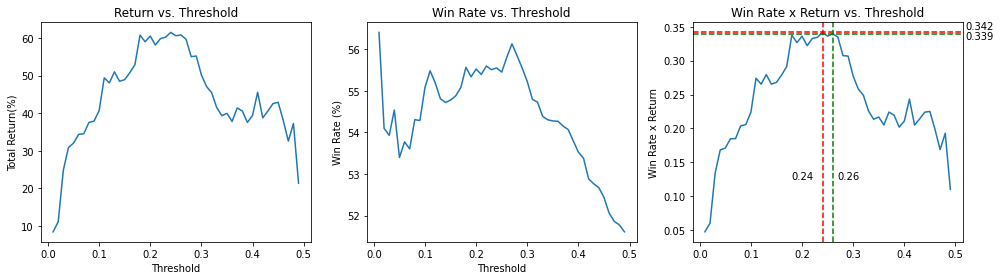

In [624]:
# Plot 3 graphs for performance analyzing
plt.rcParams["figure.figsize"] = [14, 4]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(thresholds, tol_rs, 'tab:blue')
ax1.set(xlabel = "Threshold", ylabel="Total Return(%)")
ax1.set_title("Return vs. Threshold")

ax2.plot(thresholds, winRates, 'tab:blue')
ax2.set(xlabel = "Threshold", ylabel="Win Rate (%)")
ax2.set_title("Win Rate vs. Threshold")
scores = np.multiply(np.array(tol_rs), np.array(winRates))/10000

ax3.plot(thresholds, scores)
ax3.axhline(y = max(scores), color = 'r', linestyle = '--')
ax3.text(x = 0.52, y=max(scores)+0.005, s = str(round(max(scores),3)))
best_threshold = thresholds[list(scores).index(max(scores))]
ax3.text(x = best_threshold-0.06, y=0.125, s = round(best_threshold,3))
ax3.axvline(x = best_threshold, color = 'r', linestyle='--')

temp = scores.copy()
temp.sort()
second_max = temp[-2]
second_threshold = thresholds[list(scores).index(second_max)]
ax3.axhline(y = second_max, color = 'g', linestyle = '--')
ax3.text(x = 0.52, y=second_max-0.008, s = str(round(second_max,3)))
ax3.axvline(x = thresholds[list(scores).index(second_max)], color = 'g', linestyle='--')
ax3.text(x = second_threshold+0.01, y=0.125, s = round(second_threshold,3))
ax3.set(ylabel="Win Rate x Return")
ax3.set_title("Win Rate x Return vs. Threshold")

plt.show()

In [504]:
prob = pd.read_csv(path + "IJH_MDY_cop.csv")
prob = prob.set_index(IJH_MDY_train["Date"])
len(prob)

5112

In [ ]:
hedge_ratio = pair_delta[:,0]

In [658]:
# Establish position of IJH-MDY using Kalman Filter Hedge ratio
tol_rs = []
winRates = []
for threshold in thresholds:
    lo = threshold
    hi = 1-lo
    exit = 0.5
    tags = ["IJH", "MDY"]
    pos = pd.DataFrame()
    pos['L1S2_1'] = np.zeros(len(hedge_ratio))
    pos['L1S2_2'] = np.zeros(len(hedge_ratio))
    pos['L2S1_1'] = np.zeros(len(hedge_ratio))
    pos['L2S1_2'] = np.zeros(len(hedge_ratio))
    
    # Establish position
    for i in range(1, len(pos)):
        if(prob['hfunc2'].tolist()[i] <= lo and prob['hfunc1'].tolist()[i] >= hi and pos['L2S1_2'].tolist()[i-1] != 1):
            pos.iloc[i,0] = hedge_ratio[i]
            pos.iloc[i,1] = -1 
    
        if(prob['hfunc1'].tolist()[i] <= lo and prob['hfunc2'].tolist()[i] >= hi and pos['L1S2_1'].tolist()[i-1] != -1):
            pos.iloc[i,2] = -hedge_ratio[i]
            pos.iloc[i,3] = 1
    
    
    
    tol_rs.append(calc_return(IJH_MDY_train, pos, tags))
    winRates.append(calc_winrate(IJH_MDY_train, pos, tags))

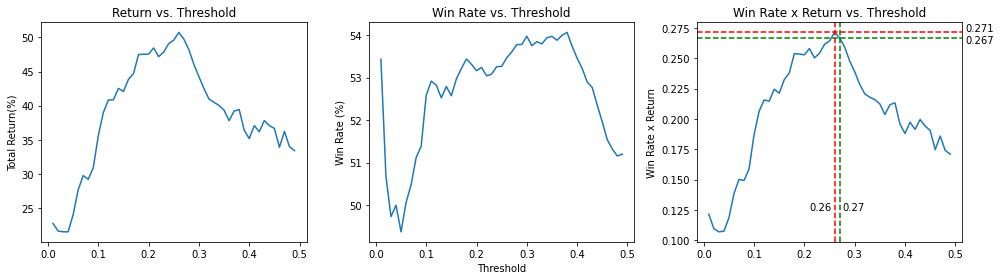

In [660]:
plt.rcParams["figure.figsize"] = [14, 4]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(thresholds, tol_rs, 'tab:blue')
ax1.set(ylabel="Total Return(%)")
ax1.set_title("Return vs. Threshold")

ax2.plot(thresholds, winRates, 'tab:blue')
ax2.set(xlabel = "Threshold", ylabel="Win Rate (%)")
ax2.set_title("Win Rate vs. Threshold")

scores = np.multiply(np.array(tol_rs), np.array(winRates))/10000
ax3.plot(thresholds, scores)
ax3.axhline(y = max(scores), color = 'r', linestyle = '--')
ax3.text(x = 0.52, y=max(scores)+0.001, s = str(round(max(scores),3)))
best_threshold = thresholds[list(scores).index(max(scores))]
ax3.text(x = best_threshold-0.05, y=0.125, s = round(best_threshold,3))
ax3.axvline(x = best_threshold, color = 'r', linestyle='--')

temp = scores.copy()
temp.sort()
second_max = temp[-2]
second_threshold = thresholds[list(scores).index(second_max)]
ax3.axhline(y = second_max, color = 'g', linestyle = '--')
ax3.text(x = 0.52, y=second_max-0.004, s = str(round(second_max,3)))
ax3.axvline(x = thresholds[list(scores).index(second_max)], color = 'g', linestyle='--')
ax3.text(x = second_threshold+0.005, y=0.125, s = round(second_threshold,3))
ax3.set(ylabel="Win Rate x Return")
ax3.set_title("Win Rate x Return vs. Threshold")

plt.show()

In [740]:
sv_hedge = sv_hedge_volproxy_df['SPY to VTI']
len(sv_hedge)

5408

In [741]:
sv_prob = pd.read_csv(path+'SPY_VTI_cop.csv')
len(sv_prob)

5408

In [751]:
len(sv_pair_dalta[:,0])

5408

In [752]:
sv_hedge = sv_pair_dalta[:,0]

In [753]:
# Establish position for SPY-VTI. *this part can be used twice, just change the sv_hedge to kalman ratio or vol proxy ratio
tol_rs = []
winRates = []
for threshold in thresholds:
    lo = threshold
    hi = 1-lo
    tags = ["SPY", "VTI"]
    pos = pd.DataFrame()
    pos['L1S2_1'] = np.zeros(len(sv_hedge)-1)
    pos['L1S2_2'] = np.zeros(len(sv_hedge)-1)
    pos['L2S1_1'] = np.zeros(len(sv_hedge)-1)
    pos['L2S1_2'] = np.zeros(len(sv_hedge)-1)
    
    for i in range(1, len(pos)):
        if(sv_prob['hfunc2'].tolist()[i] <= lo and sv_prob['hfunc1'].tolist()[i] >= hi and pos['L2S1_2'].tolist()[i-1] <= 0):
            pos.iloc[i,0] = 1
            pos.iloc[i,1] = -sv_hedge[i]
    
        if(sv_prob['hfunc1'].tolist()[i] <= lo and sv_prob['hfunc2'].tolist()[i] >= hi and pos['L1S2_1'].tolist()[i-1] >= 0):
            pos.iloc[i,2] = -1
            pos.iloc[i,3] = sv_hedge[i]
    
    tol_rs.append(calc_return(SPY_VTI_r[:-1], pos, tags))
    winRates.append(calc_winrate(SPY_VTI_r[:-1], pos, tags))

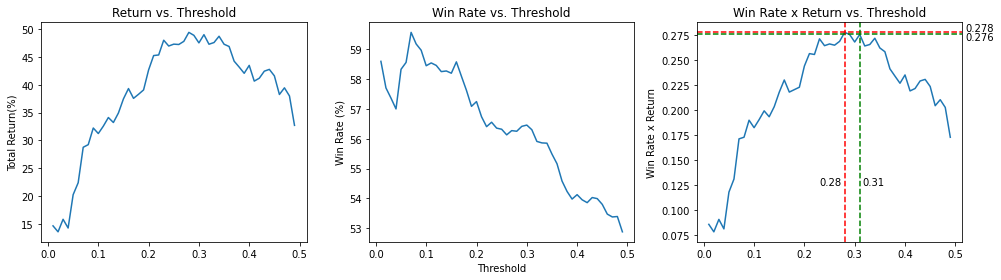

In [756]:
plt.rcParams["figure.figsize"] = [14, 4]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(thresholds, tol_rs, 'tab:blue')
ax1.set(ylabel="Total Return(%)")
ax1.set_title("Return vs. Threshold")

ax2.plot(thresholds, winRates, 'tab:blue')
ax2.set(xlabel = "Threshold", ylabel="Win Rate (%)")
ax2.set_title("Win Rate vs. Threshold")

scores = np.multiply(np.array(tol_rs), np.array(winRates))/10000
ax3.plot(thresholds, scores)
ax3.axhline(y = max(scores), color = 'r', linestyle = '--')
ax3.text(x = 0.52, y=max(scores)+0.001, s = str(round(max(scores),3)))
best_threshold = thresholds[list(scores).index(max(scores))]
ax3.text(x = best_threshold-0.05, y=0.125, s = round(best_threshold,3))
ax3.axvline(x = best_threshold, color = 'r', linestyle='--')

temp = scores.copy()
temp.sort()
second_max = temp[-2]
second_threshold = thresholds[list(scores).index(second_max)]
ax3.axhline(y = second_max, color = 'g', linestyle = '--')
ax3.text(x = 0.52, y=second_max-0.006, s = str(round(second_max,3)))
ax3.axvline(x = thresholds[list(scores).index(second_max)], color = 'g', linestyle='--')
ax3.text(x = second_threshold+0.005, y=0.125, s = round(second_threshold,3))
ax3.set(ylabel="Win Rate x Return")
ax3.set_title("Win Rate x Return vs. Threshold")

plt.show()

# Test set performance

In [625]:
test_prob = pd.read_csv(path + 'IJH_MDY_test_cop.csv')

In [626]:
len(test_prob)

5681

In [628]:
prob.tail(2)

,Unnamed: 0,hfunc1,hfunc2
Date,,,
2020-11-11,5111,0.386083,0.528447
2020-11-12,5112,0.441731,0.536612


In [629]:
test_prob = test_prob[ -(len(test_prob) - len(prob)): ]
test_prob.head(2)

,Unnamed: 0,hfunc1,hfunc2
5112,5113,0.347784,0.722730
5113,5114,0.448895,0.625724


In [630]:
# Caclulate hedge ratio
train = pd.read_csv(path + 'IJH_MDY_train.csv')
test = pd.read_csv(path + 'IJH_MDY_test.csv')
pair = train.append(test)
len(pair)

5681

In [478]:
pair.head(1)

,Unnamed: 0,Date,IJH,MDY
0,1,2000-07-21,-0.013281,-0.021249


In [661]:
len(test_prob)

569

In [480]:
# Convert the returns in terms of percentage
temp = pair[["IJH", "MDY"]] * 100
# Calculate hedge ratio
test_delta, test_cov = calc_slope_intercept_kalman(temp, ["IJH", "MDY"])
test_hedge = test_delta[:,0]
test_hedge = test_hedge[-len(test_prob):]

In [664]:
len(hedge_volproxy_df["IJH to MDY"]) - len(test_prob) 

5112

In [666]:
len(hedge_volproxy_df["IJH to MDY"][5112:]) - len(test_prob) 

0

In [749]:
sv_pair_dalta[0,:]

array([0.65800563, 0.65800563])

In [675]:
lo = 0.25
hi = 1-lo
tags = ["IJH", "MDY"]
pos = pd.DataFrame()
pos['L1S2_1'] = np.zeros(len(test_hedge))
pos['L1S2_2'] = np.zeros(len(test_hedge))
pos['L2S1_1'] = np.zeros(len(test_hedge))
pos['L2S1_2'] = np.zeros(len(test_hedge))

# Establish position
#pos['L1S2_1'] = np.where((test_prob['hfunc2'] <= lo) & (test_prob['hfunc1'] >= hi), test_hedge, 0)
#pos['L1S2_2'] = np.where((test_prob['hfunc2'] <= lo) & (test_prob['hfunc1'] >= hi), -1, 0)
#pos['L2S1_1'] = np.where((test_prob['hfunc1'] <= lo) & (test_prob['hfunc2'] >= hi), -hedge_ratio, 0)
#pos['L2S1_2'] = np.where((test_prob['hfunc1'] <= lo) & (test_prob['hfunc2'] >= hi), +1, 0)

# Establish position 
for i in range(1, len(pos)):
    if(test_prob['hfunc2'].tolist()[i] <= lo and test_prob['hfunc1'].tolist()[i]>=hi and pos['L2S1_2'].tolist()[i-1] != 1):
        pos.iloc[i,0] = test_hedge[i]
        pos.iloc[i,1] = -1
    if(test_prob['hfunc1'].tolist()[i] <= lo and test_prob['hfunc2'].tolist()[i]>=hi and pos['L1S2_2'].tolist()[i-1] != -1):
        pos.iloc[i,2] = -test_hedge[i]
        pos.iloc[i,3] = 1


test_r = calc_return(test, pos, tags)
test_winRate = calc_winrate(test, pos, tags)
print("Test set return = %0.3f" %test_r + "%")
print("Win Rate = %0.3f" %test_winRate + "%")

Test set return = 0.491%
Win Rate = 52.174%


In [394]:
test.head()

,Unnamed: 0,Date,IJH,MDY
0,4545,2018-08-14,0.009228,0.009241
1,4546,2018-08-15,-0.009144,-0.009348
2,4547,2018-08-16,0.007968,0.008274
3,4548,2018-08-17,0.005153,0.005077
4,4549,2018-08-20,0.003783,0.003741


In [552]:
entries = np.array(pos['L1S2_2']) + np.array(pos['L2S1_2'])

In [693]:
p1 = pos[["L1S2_1", "L1S2_2"]]
p1 = p1[:-1]
p2 = pos[["L2S1_1", "L2S1_2"]]
p2 = p2[:-1] 
# drop the first row of returns as there is no position for the first day
returns = np.array([test['IJH'], test['MDY']]).T
returns = returns[1:,] 

# Get total returns
returns1 = np.dot(returns, p1.to_numpy().T)
returns2 = np.dot(returns, p2.to_numpy().T)

test_returns = (returns1.diagonal() + returns2.diagonal())*100

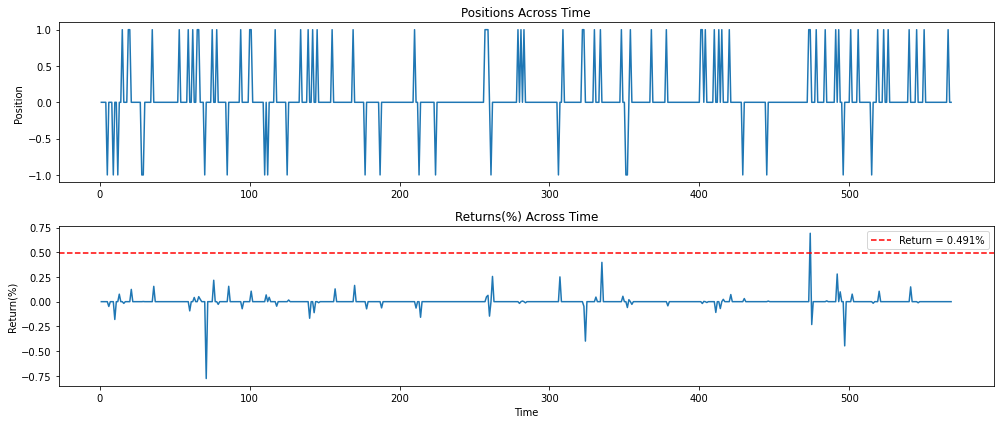

In [695]:
# Plot position overtime, and returns over time.
plt.rcParams["figure.figsize"] = [14, 6]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(list(test.index)[1:], entries[1:])
ax1.set(ylabel='Position')
ax1.set_title("Positions Across Time")

ax2.plot(list(test.index)[1:], test_returns)
ax2.set(xlabel='Time', ylabel='Return(%)')
line1 = ax2.axhline(test_r, color='r', linestyle='--')
ax2.set_title("Returns(%) Across Time")
ax2.legend([line1], ["Return = 0.491%"])
plt.show()